<a href="https://colab.research.google.com/github/dreampulse/DefinitelyTyped/blob/master/cell_count_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageDraw, ImageFilter, ImageOps
from random import randint
import tensorflow as tf
import keras

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [330]:
! git clone https://github.com/dreampulse/cell-count-experiment.git

fatal: destination path 'cell-count-experiment' already exists and is not an empty directory.


In [331]:
!ls cell-count-experiment/cell-images

Cells1BackgroundMasked.png  Cells1Mask.png  Cells2.jpg	    Cells3.jpg
Cells1Masked.png	    Cells1.png	    Cells2Mask.png  Cells3Mask.png


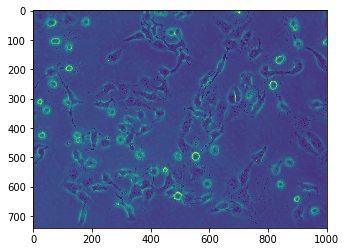

In [332]:
cells1 = Image.open("cell-count-experiment/cell-images/Cells1.png").convert('L')
cells2 = Image.open("cell-count-experiment/cell-images/Cells2.jpg").convert('L')
cells3 = Image.open("cell-count-experiment/cell-images/Cells3.jpg").convert('L')

basewidth = 1000
wpercent = (basewidth / float(cells1.size[0]))
hsize = int((float(cells1.size[1]) * float(wpercent)))
cells1 = cells1.resize((basewidth, hsize), Image.ANTIALIAS)
cells2 = cells2.resize((basewidth, hsize), Image.ANTIALIAS)
cells3 = cells3.resize((basewidth, hsize), Image.ANTIALIAS)

imshow(cells2)

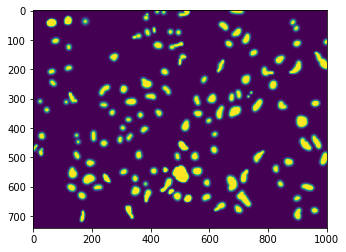

In [333]:
cells1_label = ImageOps.invert(Image.open("cell-count-experiment/cell-images/Cells1Mask.png").convert('L'))
cells2_label = ImageOps.invert(Image.open("cell-count-experiment/cell-images/Cells2Mask.png").convert('L'))
cells3_label = ImageOps.invert(Image.open("cell-count-experiment/cell-images/Cells3Mask.png").convert('L'))

cells1_label = cells1_label.resize((basewidth, hsize), Image.ANTIALIAS)
cells2_label = cells2_label.resize((basewidth, hsize), Image.ANTIALIAS)
cells3_label = cells3_label.resize((basewidth, hsize), Image.ANTIALIAS)

imshow(cells2_label)

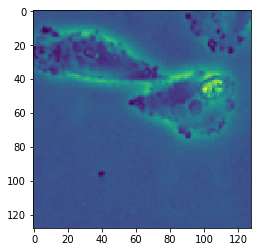

In [334]:
tiles_size = 128

def get_cropped_img(img, i, j, tiles_size):
    return img.crop((i, j, i+tiles_size, j+tiles_size))

imshow(get_cropped_img(cells1, 100, 100, tiles_size))

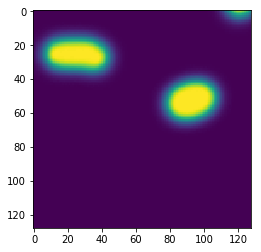

In [335]:
def get_cropped_label(img, i, j, tiles_size):
  cropped_img = img.crop((i, j, i+tiles_size, j+tiles_size))
  # cropped_label = np.array(cropped_img)
  # center_pos = int(tiles_size/2)
  # prob_cell_in_center = cropped_label[center_pos, center_pos] / 255.0
  # return cropped_img, prob_cell_in_center, cropped_label
  return cropped_img

example_cropped_img = get_cropped_label(cells1_label, 100, 100, tiles_size)
imshow(example_cropped_img)

In [381]:
def create_data(inputs):
  x_training = []
  y_training = []

  def append_data(img, label_img, step_size = 40):
    for j in range(0, img.height - tiles_size, step_size):
      for i in range(0, img.width - tiles_size, step_size):
        x_training.append(np.array(get_cropped_img(img, i, j, tiles_size)) / 255.0)
        y_training.append(np.array(get_cropped_label(label_img, i, j, tiles_size)) / 255.0)

  for img, label_img in inputs:
     append_data(img, label_img)

  # return np.array(x_training), keras.utils.to_categorical(np.where(np.array(np.array(y_training)) > .5, 1, 0), num_classes=2)
  return np.array(x_training), np.array(y_training)

x_train, y_train = create_data([(cells1, cells1_label), (cells3, cells3_label)])
x_valid, y_valid = create_data([(cells2, cells2_label)])
print("Number of test images", len(x_train))
print("Number of validation images", len(x_valid))
# x_training[0]

Number of test images 704
Number of validation images 352


In [0]:
x_train = np.expand_dims(x_train, axis=3)
x_valid = np.expand_dims(x_valid, axis=3)

y_train = np.expand_dims(y_train, axis=3)
y_valid = np.expand_dims(y_valid, axis=3)

In [0]:
# x_train.reshape(x_train.shape[0], tiles_size, tiles_size,1)

In [366]:
x_train.shape

(468, 128, 128, 1)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  """Function to add 2 convolutional layers with the parameters passed to it"""
  # first layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  """Function to define the UNET Model"""
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [368]:
x_train[0].shape[0], x_train[0].shape[1], 1

(128, 128, 1)

In [369]:
# model = keras.models.Sequential([
#     keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=x_train.shape[1:]),
#     keras.layers.MaxPooling2D(pool_size=(3,3)), 
#     keras.layers.Conv2D(64, (5, 5), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(4,4)), 
#     keras.layers.Dropout(0.5),    
#     keras.layers.Flatten(),
    
#     keras.layers.Dense(75*75, activation="sigmoid"),

#     keras.layers.Reshape((75,75))
# ])

input_img = keras.layers.Input((x_train[0].shape[0], x_train[0].shape[1], 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_196 (BatchN (None, 128, 128, 16) 64          conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_196 (Activation)     (None, 128, 128, 16) 0           batch_normalization_196[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(loss="binary_crossentropy",
#               optimizer='sgd',
              # optimizer='adam',
              optimizer=keras.optimizers.Adadelta(),
              # metrics=["binary_accuracy"]
              metrics=["accuracy"]
              )

In [423]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Train on 704 samples, validate on 352 samples
Epoch 1/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1421 - binary_accuracy: 0.6039 - val_loss: 0.1734 - val_binary_accuracy: 0.7423
Epoch 2/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1420 - binary_accuracy: 0.6039 - val_loss: 0.1771 - val_binary_accuracy: 0.7421
Epoch 3/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1421 - binary_accuracy: 0.6040 - val_loss: 0.1800 - val_binary_accuracy: 0.7400
Epoch 4/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1424 - binary_accuracy: 0.6039 - val_loss: 0.1772 - val_binary_accuracy: 0.7406
Epoch 5/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1422 - binary_accuracy: 0.6039 - val_loss: 0.1772 - val_binary_accuracy: 0.7418


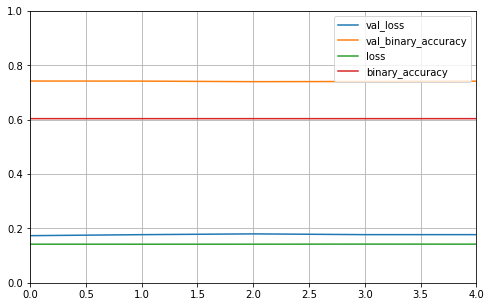

In [424]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()


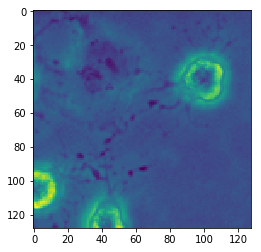

In [473]:
# Das hier ist ein Trainingsbild
img_index = 2

x_org = x_valid.reshape(x_valid.shape[0], tiles_size, tiles_size)[img_index]*255
imshow(Image.fromarray(x_org.astype(np.uint8)))

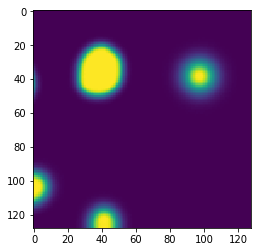

In [474]:
# Das hier sind die Labels die trainiert wurden
y_org =  y_valid.reshape(y_valid.shape[0], tiles_size, tiles_size)[img_index]*255
imshow(Image.fromarray(y_org.astype(np.uint8)))

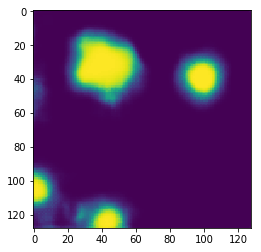

In [475]:
# Das hier hat das netzt predicted
y_pred = model.predict(np.array([x_valid[img_index]]))[0].reshape(tiles_size, tiles_size)*255
imshow(Image.fromarray(y_pred.astype(np.uint8)))

In [0]:
width_tiles = int(cells2.width/tiles_size)
height_tiles = int(cells2.height/tiles_size)

In [0]:
# make it dividable by tiles
val_img = cells2.crop((0,0,width_tiles*tiles_size, height_tiles*tiles_size))
val = np.array(val_img) / 255.0

In [0]:
imgs = []

for j in range(height_tiles):
  for i in range(width_tiles):
    imgs.append(val[j*tiles_size:(j*tiles_size)+tiles_size, i*tiles_size:(i*tiles_size)+tiles_size])

imgs = np.array(imgs).reshape(-1, tiles_size, tiles_size, 1)

# Image.fromarray((imgs[0] * 255).astype(np.uint8))

pred_imgs = model.predict(imgs)
# pred_imgs = imgs

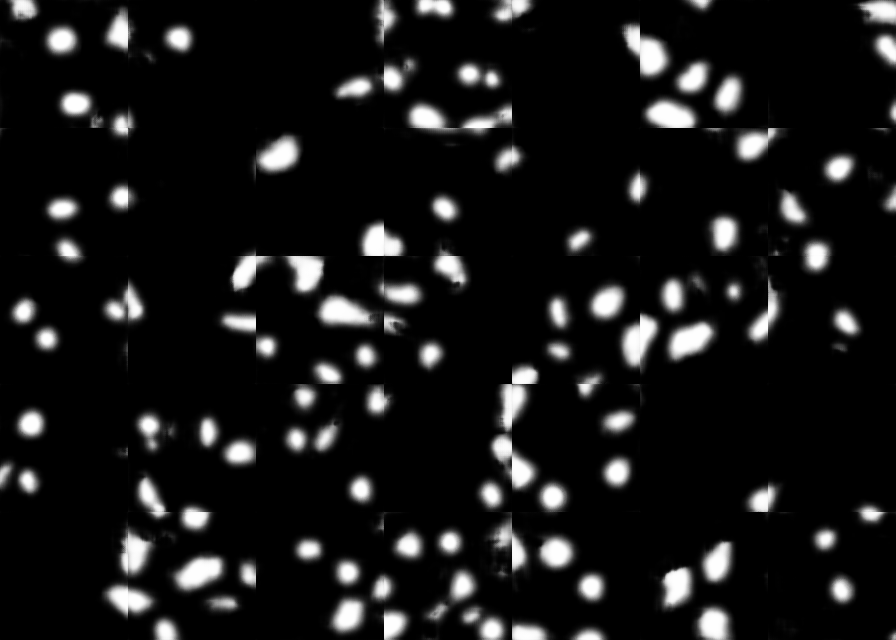

In [353]:
img = np.zeros([height_tiles*tiles_size, width_tiles*tiles_size])

n = 0
for j in range(height_tiles):
  for i in range(width_tiles):
    img[j*tiles_size:(j*tiles_size)+tiles_size, i*tiles_size:(i*tiles_size)+tiles_size] = pred_imgs[n].reshape(tiles_size, tiles_size)
    n = n + 1


Image.fromarray((img * 255).astype(np.uint8))

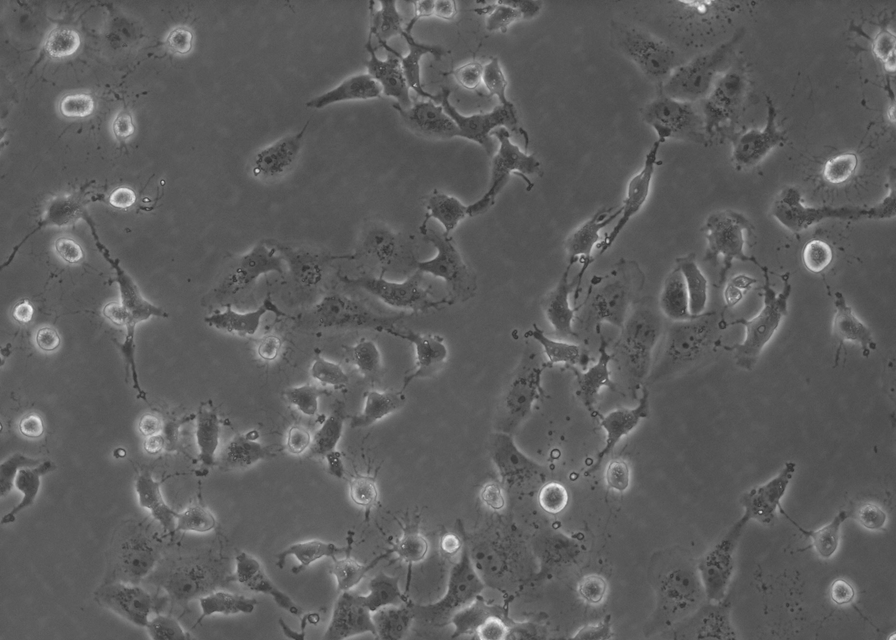

In [354]:
val_img